https://www.kaggle.com/c/ga-customer-revenue-prediction

https://www.kaggle.com/c/ga-customer-revenue-prediction/data
https://www.kaggle.com/ogrellier/teach-lightgbm-to-sum-predictions 
- describes 

What files do I need?
You will need to download train.csv and test.csv. These contain the data necessary to make predictions for each fullVisitorId listed in sample_submission.csv.

You can also access this data via BigQuery, using the example notebook provided as a way to get started. The data in train.csv is contained in the BigQuery ga_train_set dataset, and the data in test.csv is contained in the ga_test_set dataset, under the kaggle-public-datasets project, accessible through Kernels. In those BigQuery datasets, each day's worth of data is a separate table for more efficient EDA / download.

All information below pertains to the data in both CSV and BigQuery format.

What should I expect the data format to be?
Both train.csv and test.csv contain the columns listed under Data Fields. Each row in the dataset is one visit to the store. Because we are predicting the log of the total revenue per user, be aware that not all rows in test.csv will correspond to a row in the submission, but all unique fullVisitorIds will correspond to a row in the submission.

IMPORTANT: Due to the formatting of fullVisitorId you must load the Id's as strings in order for all Id's to be properly unique!
There are multiple columns which contain JSON blobs of varying depth. In one of those JSON columns, totals, the sub-column transactionRevenue contains the revenue information we are trying to predict. This sub-column exists only for the training data.

What am I predicting?
We are predicting the natural log of the sum of all transactions per user. For every user in the test set, the target is:
yuser=∑i=1ntransactionuseri
targetuser=ln(yuser+1)
File Descriptions
train.csv - the training set - contains the same data as the BigQuery rstudio_train_set.
test.csv - the test set - contains the same data as the BigQuery rstudio_test_set.
sampleSubmission.csv - a sample submission file in the correct format. Contains all fullVisitorIds in test.csv.
Data Fields
fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
channelGrouping - The channel via which the user came to the Store.
date - The date on which the user visited the Store.
device - The specifications for the device used to access the Store.
geoNetwork - This section contains information about the geography of the user.
sessionId - A unique identifier for this visit to the store.
socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
totals - This section contains aggregate values across the session.
trafficSource - This section contains information about the Traffic Source from which the session originated.
visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
visitNumber - The session number for this user. If this is the first session, then this is set to 1.
visitStartTime - The timestamp (expressed as POSIX time).
Removed Data Fields
Some fields were censored to remove target leakage. The major censored fields are listed below.

hits - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
customDimensions - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.
totals - Multiple sub-columns were removed from the totals field.

In [5]:
import json
from pandas.io.json import json_normalize

from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew, norm, entropy, gaussian_kde
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import os
from bokeh.plotting import figure, show, output_notebook
from bokeh.palettes import Spectral11, colorblind, Inferno, BuGn, brewer
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource,LinearColorMapper,BasicTicker, PrintfTickFormatter, ColorBar
import bokeh.plotting as bk

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xg
from sklearn.model_selection import GridSearchCV
from datetime import date
import calendar
from pandas.tseries.holiday import USFederalHolidayCalendar
import datetime
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, MICE
bk.output_notebook()
plt.style.use('fivethirtyeight')
%matplotlib inline

Loading BokehJS ...

# flatten json

In [2]:
def load_df(csv_path='data/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = ["{}.{}".format(column,subcolumn) for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    #print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

print(os.listdir("data"))

['test.csv', 'train.csv', 'sample_submission.csv']


In [3]:
%%time
df_small = load_df(nrows=20000)

CPU times: user 8.79 s, sys: 288 ms, total: 9.08 s
Wall time: 9.19 s


In [ ]:
%%time
df_train = load_df()
df_test = load_df("data/test.csv")

In [ ]:
%%time
df_train.to_csv("data/train_flat.csv", index=False)
df_test.to_csv("data/test_flat.csv", index=False)

# Import CSV

In [1]:
import json
from pandas.io.json import json_normalize

from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew, norm, entropy, gaussian_kde
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import os
from bokeh.plotting import figure, show, output_notebook
from bokeh.palettes import Spectral11, colorblind, Inferno, BuGn, brewer
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource,LinearColorMapper,BasicTicker, PrintfTickFormatter, ColorBar
import bokeh.plotting as bk

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xg
from sklearn.model_selection import GridSearchCV
from datetime import date
import calendar
from pandas.tseries.holiday import USFederalHolidayCalendar
import datetime
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, MICE
bk.output_notebook()
plt.style.use('fivethirtyeight')
%matplotlib inline

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Loading BokehJS ...

# FG
- change date to datetime -- DONE
- take descriptive stats aggregates of categorical vector for each user -- DONE
- visitStartTime: extract insights of time of day from this; localized to region? -- DONE
- turn categorical into dummy -- can only create aggregates when dummy features are created
- turn necessary numeric into categorical; some may be useful to bucket if needed; bucketing may be --> LAST STEP
-- user aggregates
--- count of sessions count of visits


In [2]:
path='flattened/'
train_df=pd.read_csv(path+'train_flat.csv',low_memory=False)
test_df=pd.read_csv(path+'test_flat.csv',low_memory=False)
samp_df=pd.read_csv('data/sample_submission.csv',low_memory=False)

In [3]:
df_list_str=['train_df','test_df']
count=0
for i in [train_df,test_df]:
    print df_list_str[0]
    print i.shape
    count+=1
print 'target col: '
[x for x in list(train_df) if x not in list(test_df)]

train_df
(903653, 55)
train_df
(804684, 53)
target col: 


['totals.transactionRevenue', 'trafficSource.campaignCode']

In [4]:
samp_df.head()

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.0
1,0000049363351866189,0.0
2,0000053049821714864,0.0
3,0000059488412965267,0.0
4,0000085840370633780,0.0


In [5]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [6]:
test_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20171016,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,NaN,google
1,Organic Search,20171016,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20171016,6059383810968229466,6059383810968229466_1508143220,Not Socially Engaged,1508143220,1,1508143220,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20171016,2376720078563423631,2376720078563423631_1508193530,Not Socially Engaged,1508193530,1,1508193530,Safari,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
4,Organic Search,20171016,2314544520795440038,2314544520795440038_1508217442,Not Socially Engaged,1508217442,1,1508217442,Safari,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google


In [7]:
samp_df.head()

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.0
1,0000049363351866189,0.0
2,0000053049821714864,0.0
3,0000059488412965267,0.0
4,0000085840370633780,0.0


In [8]:
# how many unique userr
print 'train'
print train_df['fullVisitorId'].nunique()
print 'test'
print test_df['fullVisitorId'].nunique()

train
714167
test
617242


# must make a dataframe at the user level

count    1.151500e+04
mean     1.337448e+08
std      4.482852e+08
min      1.000000e+04
25%      2.493000e+07
50%      4.945000e+07
75%      1.076550e+08
max      2.312950e+10
Name: totals.transactionRevenue, dtype: float64


/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


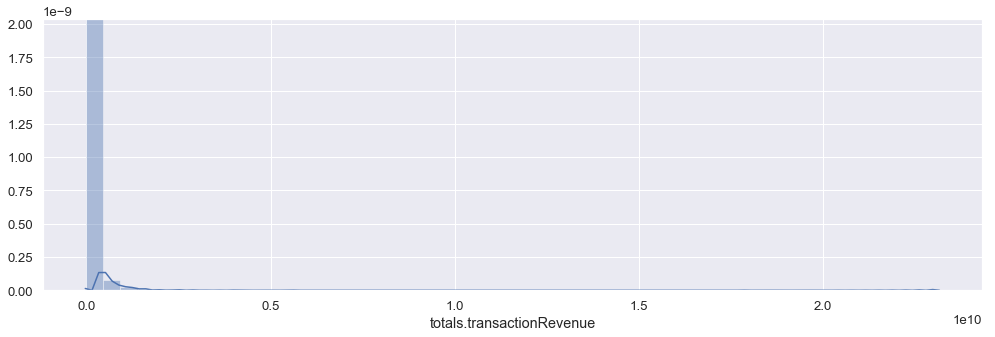

In [9]:
print train_df['totals.transactionRevenue'].describe()
plt.figure(figsize=(15,5))
sns.set(font_scale=1.2)
sns.distplot(train_df.loc[~train_df['totals.transactionRevenue'].isnull(),'totals.transactionRevenue'])

In [10]:
excluded_cols=[x for x in set(list(train_df)) if x not in set(list(test_df))]
set(list(train_df[[x for x in set(list(train_df)) if x not in excluded_cols]]))==set(list(test_df))

True

In [11]:
excluded_cols=[x for x in set(list(train_df)) if x not in set(list(test_df))]
merged_df=pd.concat([train_df[[x for x in set(list(train_df)) if x not in excluded_cols]],test_df]).reset_index(drop=True)


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


In [12]:
merged_df['date']=pd.to_datetime(merged_df['date'].apply(lambda a: datetime.datetime.strptime(str(a), '%Y%m%d').strftime('%m/%d/%Y')))

In [13]:
print merged_df['date'].describe()
# bokeh

time_analysis=pd.DataFrame(merged_df['date'])
time_analysis['frequency']=1
time_analysis['date']=pd.to_datetime(time_analysis['date'])
time_analysis=time_analysis.set_index(['date'])

TOOLS = 'save,pan,box_zoom,reset,wheel_zoom,hover'
p = figure(title="frequency of visits per day", y_axis_type="linear", plot_height = 400, x_axis_type='datetime',
           tools = TOOLS, plot_width = 800)
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Number of Visits'
p.line(time_analysis.resample('D').count().reset_index()['date'], \
       time_analysis.resample('D').count().reset_index()['frequency'],line_color="purple", line_width = 3)



hover=HoverTool(tooltips=[
    ("Date", "@x{%F}"),  # must specify desired format here
    ("Number of Visits", "@y")
], formatters={"x":"datetime"}, mode='vline')
p.add_tools(hover)


#output_file("line_chart.html", title="Line Chart")
show(p,notebook_handle=True)

count                 1708337
unique                    638
top       2017-12-12 00:00:00
freq                     9234
first     2016-08-01 00:00:00
last      2018-04-30 00:00:00
Name: date, dtype: object


# replace not available in dataset with null

In [14]:
merged_df=merged_df.replace('not available in demo dataset',np.nan)
test_df=test_df.replace('not available in demo dataset',np.nan)
train_df=train_df.replace('not available in demo dataset',np.nan)

# drop null cols if over 20% null in test set


In [15]:
null_cols=(test_df.isnull().sum()/test_df.shape[0])[(test_df.isnull().sum()/test_df.shape[0]>0.2)].index
merged_df=merged_df[[x for x in list(merged_df) if x not in null_cols]]

In [16]:
print null_cols

Index([u'device.browserSize', u'device.browserVersion', u'device.flashVersion',
       u'device.language', u'device.mobileDeviceBranding',
       u'device.mobileDeviceInfo', u'device.mobileDeviceMarketingName',
       u'device.mobileDeviceModel', u'device.mobileInputSelector',
       u'device.operatingSystemVersion', u'device.screenColors',
       u'device.screenResolution', u'geoNetwork.city', u'geoNetwork.cityId',
       u'geoNetwork.latitude', u'geoNetwork.longitude', u'geoNetwork.metro',
       u'geoNetwork.networkLocation', u'geoNetwork.region', u'totals.bounces',
       u'totals.newVisits', u'trafficSource.adContent',
       u'trafficSource.adwordsClickInfo.adNetworkType',
       u'trafficSource.adwordsClickInfo.criteriaParameters',
       u'trafficSource.adwordsClickInfo.gclId',
       u'trafficSource.adwordsClickInfo.isVideoAd',
       u'trafficSource.adwordsClickInfo.page',
       u'trafficSource.adwordsClickInfo.slot', u'trafficSource.isTrueDirect',
       u'trafficSource.key

# drop columns for those that only have one value

In [17]:
# remove useless columns 
unique_cols=merged_df.nunique().sort_values()
merged_df=merged_df[[x for x in set(list(merged_df)) if x not in set(unique_cols[unique_cols==1].index)]]

# drop columns that have a different values for every instance/row

In [18]:
print 'columns that have do not have duplicate values and must be considered to be dropped'
print [x for x in set(list(merged_df)) if x in set(unique_cols[unique_cols==len(merged_df)].index)]

columns that have do not have duplicate values and must be considered to be dropped
[]


# Feature Generation

## Dataframes to concat
- datetimefeats
- dummydf
- merged_df['visitNumber']
- totals.pageviews - either choose to keep as null or drop or impute missing values

# Date Values for Seasonality and Holiday

In [19]:
# date features 1
min_date=min(merged_df['date'])
datefeats1=pd.DataFrame({'visit_year':merged_df['date'].apply(lambda x: x.year),\
'visit_month': merged_df['date'].apply(lambda x: x.month),
 'visit_day': merged_df['date'].apply(lambda x: x.day),
 'day_of_year': merged_df['date'].apply(lambda x: x.timetuple().tm_yday),
 'day_of_week': merged_df['date'].apply(lambda x: x.timetuple().tm_wday),
 'day_of_cycle': merged_df['date'].apply(lambda x: (x-min_date).days+1),
 'weekday_name': merged_df['date'].apply(lambda x: calendar.day_name[x.weekday()])
})

In [20]:
#create dataframe of holidays
cal = USFederalHolidayCalendar()
more_holidays=['01/01/2012','04/08/2012','03/31/2013','04/20/2014','12/24/2012','12/24/2013','12/24/2014']
holidays_df=pd.concat([cal.holidays(start='2011-12-31', end='2014-12-31').to_frame().reset_index(drop=True),pd.DataFrame(more_holidays)]).apply(lambda x: pd.to_datetime(x)).reset_index(drop=True)
holidays_df=holidays_df.iloc[1:,:]

# mark holidays and x days away from holiday
holidays_list=set(holidays_df[0])

In [21]:
weekends=set(['Sunday','Saturday'])

datefeats2=pd.DataFrame({'is_weekend':datefeats1['weekday_name'].apply(lambda x: 1 if x in weekends else 0),
'is_weekday':datefeats1['weekday_name'].apply(lambda x: 0 if x in weekends else 1),
'on_holiday':merged_df['date'].apply(lambda x: 1 if x in holidays_list else 0)})

In [22]:
#within one day of holiday but not on holiday
holiday_1day=set(pd.concat([holidays_df.apply(lambda x: x + datetime.timedelta(days=1)),holidays_df.apply(lambda x: x + datetime.timedelta(days=-1))])[0])

holiday_prox_df=merged_df.copy()
holiday_prox_df['1d_away_holiday']=holiday_prox_df['date'].apply(lambda x: 1 if x in holiday_1day else 0)

#within 2 days of holiday
holiday_1day.update(pd.concat([holidays_df.apply(lambda x: x + datetime.timedelta(days=2)),holidays_df.apply(lambda x: x + datetime.timedelta(days=-2))])[0].tolist())
holiday_prox_df['2d_away_holiday']=holiday_prox_df['date'].apply(lambda x: 1 if x in holiday_1day else 0)

#within 3 days of holiday
holiday_1day.update(pd.concat([holidays_df.apply(lambda x: x + datetime.timedelta(days=3)),holidays_df.apply(lambda x: x + datetime.timedelta(days=-3))])[0].tolist())
holiday_prox_df['3d_away_holiday']=holiday_prox_df['date'].apply(lambda x: 1 if x in holiday_1day else 0)

#within 7 days of holiday
for d in [4,5,6,7]:
    holiday_1day.update(pd.concat([holidays_df.apply(lambda x: x + datetime.timedelta(days=d)),holidays_df.apply(lambda x: x + datetime.timedelta(days=-d))])[0].tolist())
holiday_prox_df['7d_away_holiday']=holiday_prox_df['date'].apply(lambda x: 1 if x in holiday_1day else 0)

holiday_prox_df=holiday_prox_df[['1d_away_holiday','2d_away_holiday','3d_away_holiday','7d_away_holiday']]

In [23]:
datetimefeats=pd.concat([datefeats1,datefeats2,holiday_prox_df],axis=1)

# Create datetime feats for visit time
export to tableau to see if there is anything within a daily occurence

### observations
just hour


In [24]:
datetimefeats['visit_hour']=merged_df['visitStartTime'].apply(lambda x: datetime.datetime.fromtimestamp(x).hour)

# Categorical features
## look for numeric values that behave as if categorical -- scratched for first round of predictions

In [25]:
# look for numerical values that act as cat
actual_cat=[]
actual_int=[]
merged_ints=merged_df[merged_df.dtypes[(merged_df.dtypes!='object')&(merged_df.dtypes!='bool')].index]

for col in list(merged_ints):
    if merged_ints[col].nunique()*1.0/merged_ints.shape[0] <= 0.2: # if the number of unique values is less than 20%
        actual_cat.append(col)
    else:
        actual_int.append(col)

print 'actually_categorical'
print actual_cat
print 'actually numeric'
print actual_int

actually_categorical
['date', 'totals.pageviews', 'visitNumber', 'totals.hits']
actually numeric
['visitId', 'visitStartTime']


## observations
- from actually categorical drop date 
- to bucket: pageviews, visitnumber, totals.hits
- drop visitId and visitStartTime

       totals.pageviews   visitNumber   totals.hits
count      1.708098e+06  1.708337e+06  1.708337e+06
mean       3.696202e+00  2.335170e+00  4.429598e+00
std        6.473237e+00  9.354034e+00  8.991748e+00
min        1.000000e+00  1.000000e+00  1.000000e+00
25%        1.000000e+00  1.000000e+00  1.000000e+00
50%        1.000000e+00  1.000000e+00  1.000000e+00
75%        4.000000e+00  1.000000e+00  4.000000e+00
max        5.000000e+02  4.570000e+02  5.000000e+02


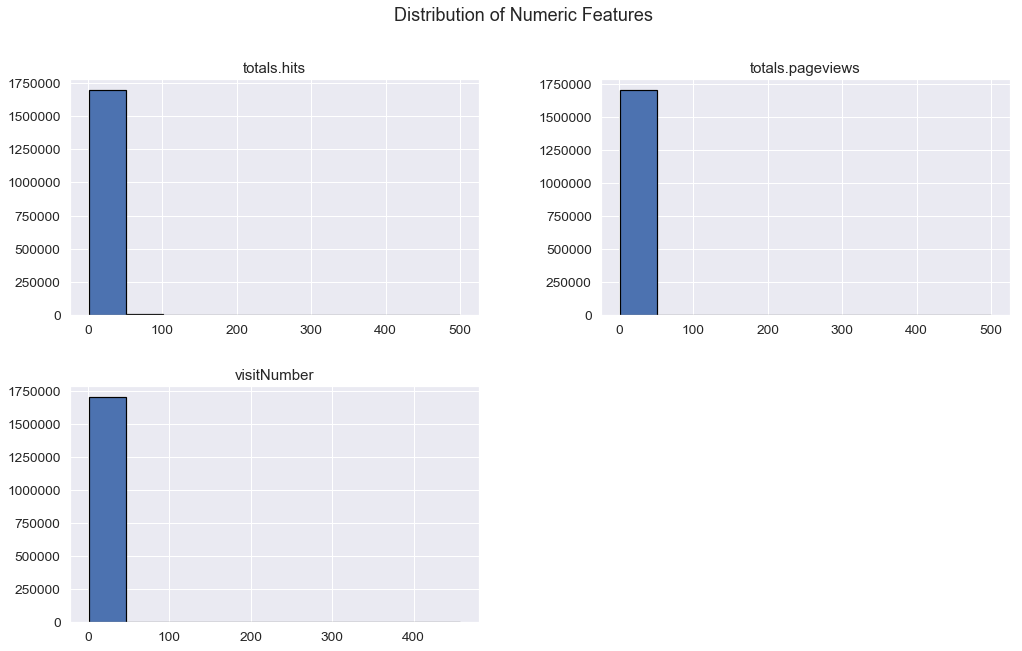

In [26]:
sns.set(font_scale=1.25)

print merged_df[actual_cat].describe()
merged_df[actual_cat].hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(15,10)
plt.suptitle("Distribution of Numeric Features")
plt.show()

# create dummies from actual objects// for the sake of computation speed under 300 unique values; for others just treat as numeric if possible
- only treat visitNumber as numeric rest must be dummied
- totals.pageviews must be imputed after

In [27]:
# merged object dtypes with numeric cats
unique_cats=merged_df[merged_df.dtypes[(merged_df.dtypes=='object')].index.tolist()+actual_cat].nunique().sort_values(ascending=False)
dummy_cols=unique_cats[unique_cats<300].index.tolist()
num_cols=unique_cats[unique_cats>=300].index.tolist()

In [28]:
print 'columns to dummy'
dummy_cols

columns to dummy


['totals.hits',
 'totals.pageviews',
 'geoNetwork.country',
 'device.browser',
 'trafficSource.campaign',
 'device.operatingSystem',
 'geoNetwork.subContinent',
 'channelGrouping',
 'trafficSource.medium',
 'geoNetwork.continent',
 'device.deviceCategory']

In [29]:
# dummy categorical features
cat_dummy=pd.get_dummies(merged_df[dummy_cols].applymap(str))

In [30]:
# dummmy datetime features
datetime_dummy=pd.get_dummies(datetimefeats.applymap(str))

# concat all features
- merged_df['visitNumber'] -> scale first // numerical
- dummy_cols
- datetime_dummy

In [31]:
merged2=pd.concat([pd.DataFrame({'visitor_id':pd.concat([train_df['fullVisitorId'],test_df['fullVisitorId']])}).reset_index(drop=True),pd.DataFrame(merged_df['visitNumber']),cat_dummy,datetime_dummy],axis=1)

In [32]:
merged2.to_csv('exports/merged2.csv',index=False)

# User Aggregated Features

### first thought just do a sum of all columns and figure out which ones are not binary
- max visit number per user
- sum of pageviews per user
- sum of totals.hits
- sum of dummy cols
- sum of datetime too.

### averages instead of sums?

In [33]:
import json
from pandas.io.json import json_normalize

from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew, norm, entropy, gaussian_kde
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import os
from bokeh.plotting import figure, show, output_notebook
from bokeh.palettes import Spectral11, colorblind, Inferno, BuGn, brewer
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource,LinearColorMapper,BasicTicker, PrintfTickFormatter, ColorBar
import bokeh.plotting as bk

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xg
from sklearn.model_selection import GridSearchCV
from datetime import date
import calendar
from pandas.tseries.holiday import USFederalHolidayCalendar
import datetime
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, MICE
bk.output_notebook()
plt.style.use('fivethirtyeight')
%matplotlib inline

Loading BokehJS ...

In [34]:
merged2=pd.read_csv('exports/merged2.csv')

/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
merged2.head()

,visitor_id,visitNumber,totals.hits_1,totals.hits_10,totals.hits_100,totals.hits_101,totals.hits_102,totals.hits_103,totals.hits_104,totals.hits_105,...,visit_hour_21,visit_hour_22,visit_hour_23,visit_hour_3,visit_hour_4,visit_hour_5,visit_hour_6,visit_hour_7,visit_hour_8,visit_hour_9
0,1131660440785968503,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,377306020877927890,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,3895546263509774583,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4763447161404445595,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,27294437909732085,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [40]:
'totals.hits' in dummy_cols

True

In [41]:
print merged2.shape
merged2.head()

(1708337, 2061)


,visitor_id,visitNumber,totals.hits_1,totals.hits_10,totals.hits_100,totals.hits_101,totals.hits_102,totals.hits_103,totals.hits_104,totals.hits_105,...,visit_hour_21,visit_hour_22,visit_hour_23,visit_hour_3,visit_hour_4,visit_hour_5,visit_hour_6,visit_hour_7,visit_hour_8,visit_hour_9
0,1131660440785968503,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,377306020877927890,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,3895546263509774583,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4763447161404445595,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,27294437909732085,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
merged3=merged2.groupby(['visitor_id']).sum()

In [ ]:
temp=merged2.groupby(['visitor_id'])['visitNumber'].value_counts()

In [ ]:
pd.DataFrame(temp)

In [ ]:
temp2=pd.DataFrame(merged2.groupby(['visitor_id'])['totals.hits'].value_counts())

In [ ]:
merged_df[merged_df['totals.hit']==str(max(merged_df['totals.hit'].applymap(int)))]

In [199]:
temp2

totals.hits
visitor_id          totals.hits             
0000000259678714014 3                      1
                    16                     1
0000010278554503158 11                     1
0000020424342248747 17                     1
0000027376579751715 6                      1
0000039460501403861 2                      1
0000040862739425590 2                      1
                    3                      1
0000049363351866189 1                      3
000005103959234087  10                     1
0000053049821714864 1                      1
0000059488412965267 1                      3
0000062267706107999 1                      1
0000068403966359845 2                      1
0000085059828173212 1                      1
0000085840370633780 2                      1
0000091131414287111 1                      1
0000093957001069502 2                      1
0000114156543135683 1                      1
0000117255350596610 44                     1
0000118334805178127 1                      1
0000130646294093000 3                      1
0000150005271820273 5                      1
0000152474579038632 2                      1
0000166374699289385 5                      1
0000168159078983594 76                     1
0000174067426171406 7                      1
                    28                     1
0000174453501096099 1                      1
0000176652019531658 1                      1
...                                      ...
9999801229043043045 30                     1
9999803502828528029 1                      1
9999803509476553670 1                      1
9999818112872622034 48                     1
9999819762744314978 1                      3
                    2                      3
9999824060591971928 1                      1
9999824326944242344 2                      1
                    19                     1
9999825631375939274 10                     1
9999834067265202923 1                      1
9999841005270636052 1                      1
9999860794386137754 10                     1
9999882818693474736 61                     1
9999887420016307570 7                      1
9999905960465191827 2                      1
9999906724458612544 4                      1
9999941518946450908 1                      1
9999944980984230465 1                      1
9999955365228667450 2                      1
9999963186378918199 1                      1
9999969142283897422 6                      1
999997225970956660  1                      1
999997550040396460  1                      1
                    2                      1
9999978264901065827 1                      1
9999985820452794361 5                      1
                    6                      1
9999986437109498564 2                      1
9999997304197521748 3                      1

[1553030 rows x 1 columns]

In [200]:
temp3=pd.DataFrame(merged2.groupby(['visitor_id'])['totals.pageviews'].value_counts())

In [201]:
temp3

totals.pageviews
visitor_id          totals.pageviews                  
0000000259678714014 3.0                              1
                    10.0                             1
0000010278554503158 8.0                              1
0000020424342248747 13.0                             1
0000027376579751715 5.0                              1
0000039460501403861 2.0                              1
0000040862739425590 2.0                              1
                    3.0                              1
0000049363351866189 1.0                              3
000005103959234087  8.0                              1
0000053049821714864 1.0                              1
0000059488412965267 1.0                              3
0000062267706107999 1.0                              1
0000068403966359845 2.0                              1
0000085059828173212 1.0                              1
0000085840370633780 2.0                              1
0000091131414287111 1.0                              1
0000093957001069502 2.0                              1
0000114156543135683 1.0                              1
0000117255350596610 33.0                             1
0000118334805178127 1.0                              1
0000130646294093000 2.0                              1
0000150005271820273 5.0                              1
0000152474579038632 2.0                              1
0000166374699289385 5.0                              1
0000168159078983594 56.0                             1
0000174067426171406 5.0                              1
                    25.0                             1
0000174453501096099 1.0                              1
0000176652019531658 1.0                              1
...                                                ...
9999801229043043045 23.0                             1
9999803502828528029 1.0                              1
9999803509476553670 1.0                              1
9999818112872622034 29.0                             1
9999819762744314978 1.0                              3
                    2.0                              3
9999824060591971928 1.0                              1
9999824326944242344 2.0                              1
                    15.0                             1
9999825631375939274 9.0                              1
9999834067265202923 1.0                              1
9999841005270636052 1.0                              1
9999860794386137754 9.0                              1
9999882818693474736 39.0                             1
9999887420016307570 4.0                              1
9999905960465191827 2.0                              1
9999906724458612544 4.0                              1
9999941518946450908 1.0                              1
9999944980984230465 1.0                              1
9999955365228667450 2.0                              1
9999963186378918199 1.0                              1
9999969142283897422 6.0                              1
999997225970956660  1.0                              1
999997550040396460  1.0                              1
                    2.0                              1
9999978264901065827 1.0                              1
9999985820452794361 5.0                              1
                    6.0                              1
9999986437109498564 2.0                              1
9999997304197521748 3.0                              1

[1548152 rows x 1 columns]

# create datetime features from date
### viz of visits per day